<a href="https://colab.research.google.com/github/arthiv21/PBMC_Classifier/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
import math


This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labels.csv")
counts_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_counts.csv")
counts_pd = counts_pd.drop(columns=[counts_pd.columns[0]])         # drops the barcode column to allow counts_pd to be a table of floats

In [ ]:
# Shuffle data and split into test and train data
# Shufflesplit outputs indices that correspond to the train and test data
ss = ShuffleSplit(n_splits=1, test_size=0.2)

for train_indices, test_indices in ss.split(counts_pd):
  counts_train, counts_test = counts_pd.iloc[train_indices].to_numpy(), counts_pd.loc[test_indices].to_numpy()
  labels_train, labels_test = labels_pd.loc[train_indices], labels_pd.loc[test_indices]

# counts_train is a numpy array, need to be converted into a tensor
counts_train = torch.tensor(counts_train, dtype=torch.float32)

Fully connected neural network for autoencoder.

In [ ]:
# Autoencoder class

class Autoencoder(nn.Module):
    def __init__(self, in_out_dim):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=in_out_dim, out_features=128)
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=32)

        # Latent representation of 32 features
        self.decoder_hidden_layer = nn.Linear(in_features=32, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=in_out_dim)

    def forward(self, features, return_encoding=False):
        encoded = self.encoder_hidden_layer(features)
        encoded  = torch.relu(encoded)
        encoded  = self.encoder_output_layer(encoded)
        encoded = torch.relu(encoded)
        decoded = self.decoder_hidden_layer(encoded)

        decoded = torch.relu(decoded)
        reconstructed = self.decoder_output_layer(decoded)

        # if return encoding is True, return the reconstructed data and the encoded latent space representation
        if return_encoding:
            return reconstructed, encoded
        return reconstructed

Train autoencoding using MSE loss.

Identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

Aim for 0.9 MSE loss on test set, 0.95 with regularization.

In [ ]:
# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(counts_train.shape[1]).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
loss_func = nn.MSELoss()

In [ ]:
# Train the model

batch_size = 32     # manually train the data through batches, rather than using a DataLoader
batches = math.ceil(len(counts_train) / batch_size)
epochs = 10
l1_param = 0.0001      # how strongly to enforce l1 regularization

for epoch in range(epochs):
        loss = 0
        l1_loss = 0
        encoded_to_original_index = {}         # encoded index to original index

        for i in range(batches):
            X_batch = torch.tensor(counts_train[i*batch_size:i*batch_size + batch_size], dtype=torch.float32)    # unsupervised learning focuses on X data (labels aren't necessary)

            # compute reconstructions and encoded
            outputs, encoded = model(X_batch, return_encoding=True)

            # apply l1 regulirzation to the mean
            # can also retieve the weights of the model and have those minimized instead
            l1_regularization = l1_param * torch.mean(torch.abs(encoded))
            l1_loss += l1_regularization
            train_loss = loss_func(outputs, X_batch) + l1_regularization

            # these 3 functions will follow you whenever you train a model with PyTorch
            optimizer.zero_grad()   # erases the gradients from the previous epoch (sets all gradients to 0)
            train_loss.backward()         # calculates the gradients with respect to every single weight matrix in the model
            optimizer.step()        # takes ONE learning step with the gradients just calculated

            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / batches

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        #display l1 loss
        print("loss from l1:", l1_loss/batches)



<ipython-input-34-cd75bfe8c3db>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(counts_train[i*batch_size:i*batch_size + batch_size], dtype=torch.float32)    # unsupervised learning focuses on X data (labels aren't necessary)


epoch : 1/10, loss = 1.011280
loss from l1: tensor(1.0998e-05, grad_fn=<DivBackward0>)
epoch : 2/10, loss = 0.963965
loss from l1: tensor(3.3983e-05, grad_fn=<DivBackward0>)
epoch : 3/10, loss = 0.906801
loss from l1: tensor(5.3963e-05, grad_fn=<DivBackward0>)
epoch : 4/10, loss = 0.870296
loss from l1: tensor(6.7311e-05, grad_fn=<DivBackward0>)
epoch : 5/10, loss = 0.847043
loss from l1: tensor(7.5937e-05, grad_fn=<DivBackward0>)
epoch : 6/10, loss = 0.835095
loss from l1: tensor(8.1907e-05, grad_fn=<DivBackward0>)
epoch : 7/10, loss = 0.825636
loss from l1: tensor(8.5833e-05, grad_fn=<DivBackward0>)
epoch : 8/10, loss = 0.819031
loss from l1: tensor(8.8353e-05, grad_fn=<DivBackward0>)
epoch : 9/10, loss = 0.811260
loss from l1: tensor(9.0162e-05, grad_fn=<DivBackward0>)
epoch : 10/10, loss = 0.802941
loss from l1: tensor(9.4465e-05, grad_fn=<DivBackward0>)


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

Compare the results of PCA, t-SNE, and autoencoder as ways to visualize the data.

In [ ]:
# Convert labels_pd to a numpy array
labels_col = labels_pd['bulk_labels']      # recall the labels file has two columns, we only care about the second one with the actual cell labels
labels_np = labels_col.values.ravel()

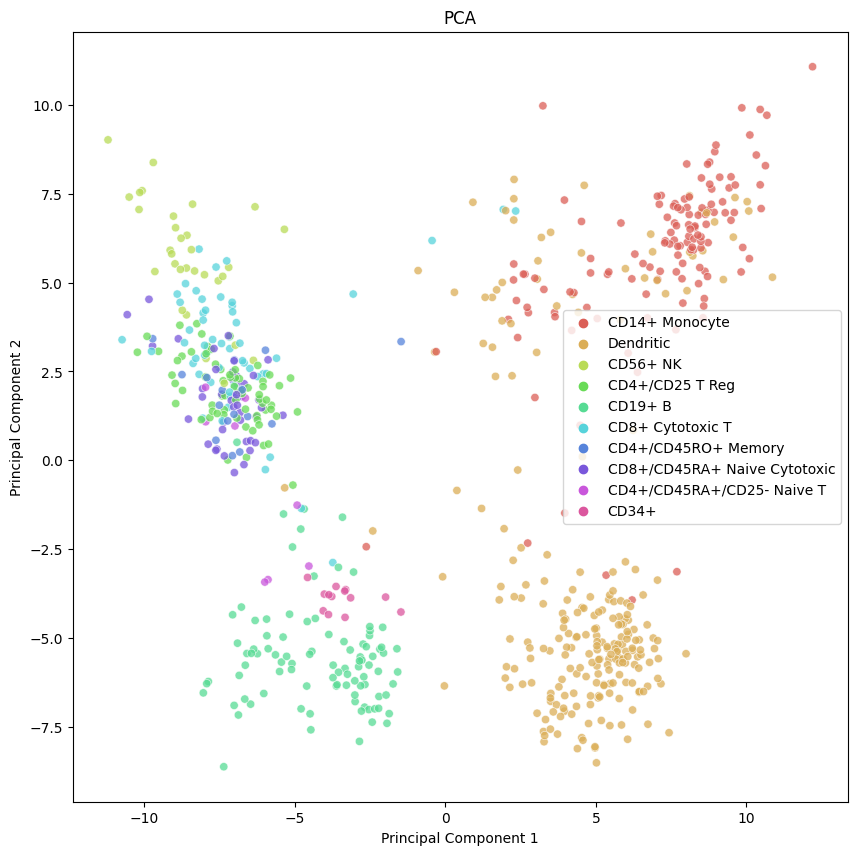

In [ ]:
# Carry out PCA on the counts data, we want the first 2 principal components
# counts_pd is a 2D array where each column is a feature and each row is a sample
pca = PCA(n_components=2)
X_pca = pca.fit_transform(counts_pd)

# Visualize X_pca
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=labels_np,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.title("PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

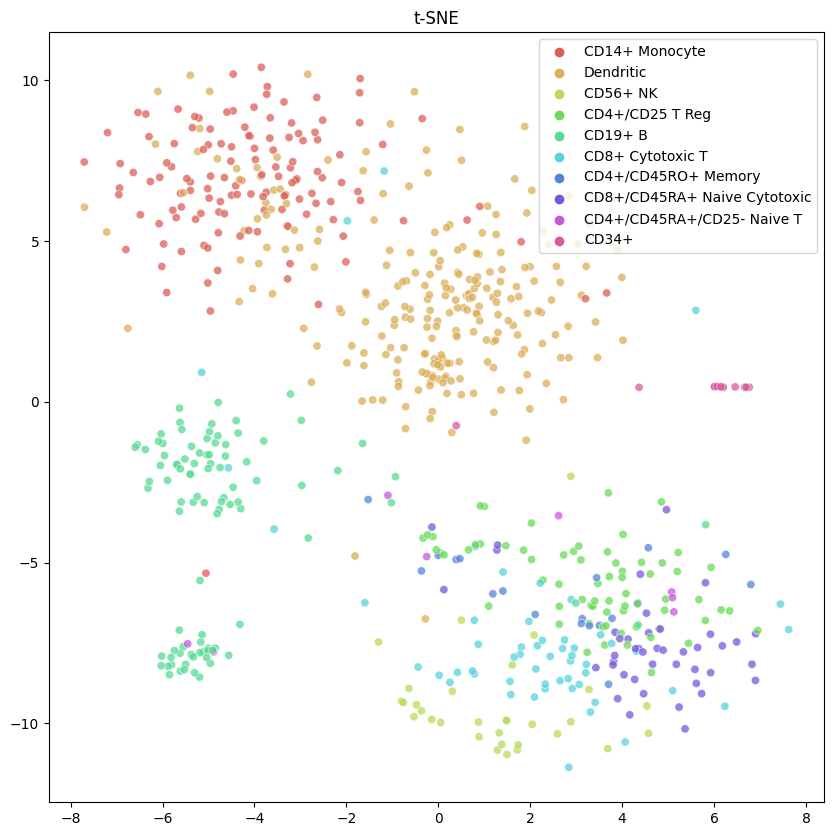

In [ ]:
# Carry out t-SNE on the counts data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(counts_pd)

# Visualize X_tsne
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=labels_np,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)

plt.title("t-SNE")
plt.show()

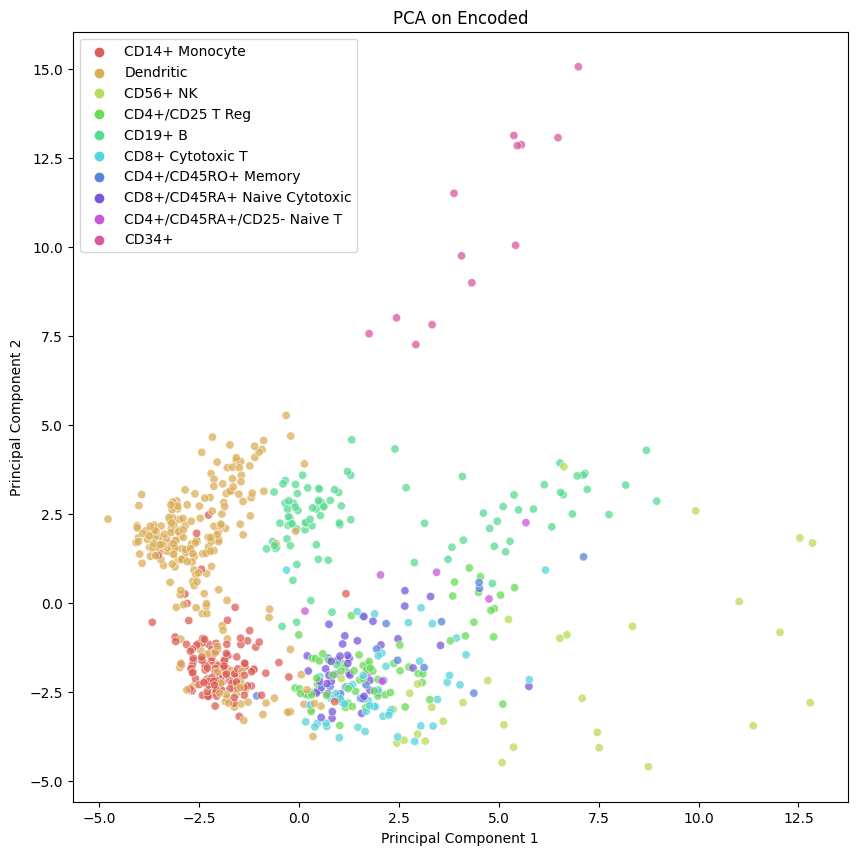

In [ ]:
# PCA on the latent space representation

# pass through all your data into the model, which has already been trained in the training loop
counts_np = counts_pd.to_numpy()
counts_tensor = torch.tensor(counts_np, dtype=torch.float32)
outputs_all_samples, encoded_all_samples = model(counts_tensor, return_encoding=True)

pca1 = PCA(n_components=2)
encoded_all_samples_np = encoded_all_samples.detach().numpy()      # convert to numpy array so can pass into pca.fit_transform
encoded_pca = pca1.fit_transform(encoded_all_samples_np)

# Visualize encoded_pca
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=encoded_pca[:,0], y=encoded_pca[:,1],
    hue=labels_np,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.title("PCA on Encoded")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

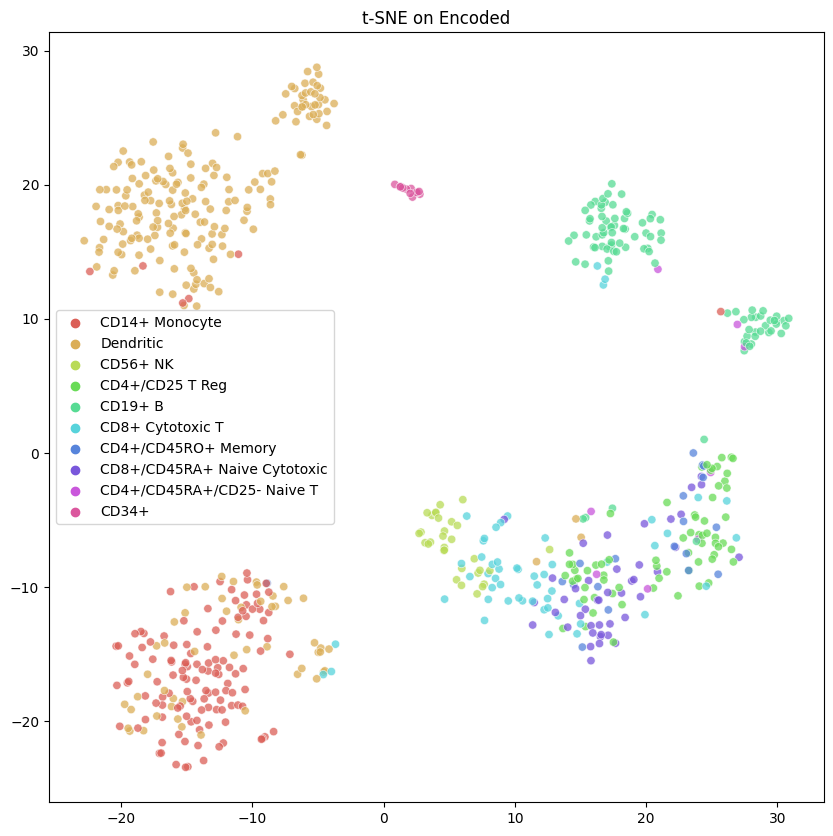

In [ ]:
# t-SNE on the latent space representation
tsne1 = TSNE(n_components=2)
encoded_tsne = tsne1.fit_transform(encoded_all_samples_np)

# Visualize X_pca
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=encoded_tsne[:,0], y=encoded_tsne[:,1],
    hue=labels_np,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.title("t-SNE on Encoded")
plt.show()

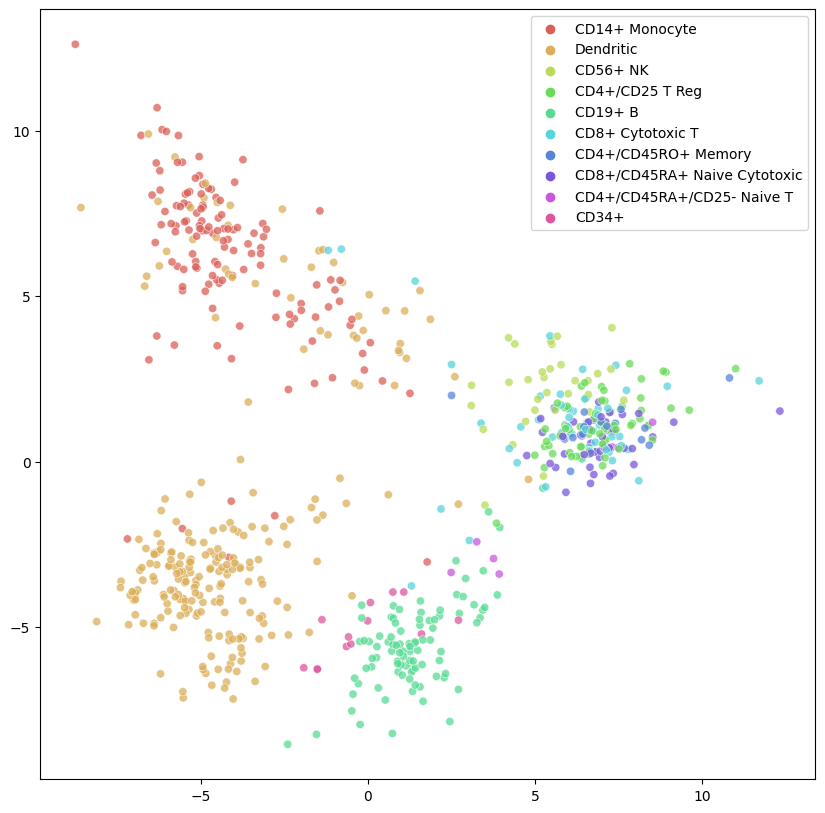

In [ ]:
# running PCA on the outputs of the encoder (just to validate the encoder is working)
pca2 = PCA(n_components=2)
outputs_all_samples_np = outputs_all_samples.detach().numpy()      # convert to numpy array so can pass into pca.fit_transform
decoded_pca = pca1.fit_transform(outputs_all_samples_np)

# Visualize X_pca
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=decoded_pca[:,0], y=decoded_pca[:,1],
    hue=labels_np,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()